In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

DATA_DIR = '../results/2023-07-21/transfer_multi_eval/REP_GDSC'

In [2]:
def read_pickle(fn):
    with open(fn, 'rb') as f:
        v = pickle.load(f)
    return v

In [3]:
def rsq_results(eval_type, r_max, k_max, s_max, m_max):
    arr = np.ones((r_max, k_max))
    for r in range(1, r_max + 1):
        for k in range(1, k_max + 1):
            # average over single values for each split_seed
            split_res = []
            for s in range(1, s_max + 1):
                # get the max over all model_seeds
                model_res = []
                for m in range(1, m_max + 1):
                    fn = DATA_DIR + '/' + str(r) + '/' + str(k) + '/' + str(s) + '/' + str(m) + '.pkl'
                    val = read_pickle(fn)
                    if eval_type == 'train':
                        res = val['rsq_train']
                    elif eval_type == 'test':
                        res = val['rsq_test']
                    else:
                        print('Error! Eval type must be train or test')
                    # add value to models list
                    model_res.append(res)
                split_res.append(np.max(np.array(model_res)))
            arr[r-1, k-1] = np.mean(np.array(split_res))
    return arr

In [10]:
def read_rsq_arr(eval_type, r_max, k_max, s_max, m_max):
    arr = np.ones((r_max, k_max, s_max, m_max)) * np.inf
    for r in range(1, r_max + 1):
        for k in range(1, k_max + 1):
            for s in range(1, s_max + 1):
                for m in range(1, m_max + 1):
                    fn = DATA_DIR + '/' + str(r) + '/' + str(k) + '/' + str(s) + '/' + str(m) + '.pkl'
                    val = read_pickle(fn)
                    if eval_type == 'train':
                        res = val['rsq_train']
                    elif eval_type == 'test':
                        res = val['rsq_test']
                    else:
                        print('Error! Eval type must be train or test')
                    arr[r-1, k-1, s-1, m-1] = res
    assert np.sum(np.sum(np.sum(np.sum(arr == np.inf)))) == 0
    return arr

In [58]:
def model_selection(arr):
    assert len(arr.shape) == 4
    r_dim, k_dim, s_dim, m_dim = arr.shape
    model_idx = np.ones((r_dim, k_dim, s_dim)) * np.inf
    for r in range(0, r_dim):
        for k in range(0, k_dim):
            for s in range(0, s_dim):
                model_idx[r, k, s] = np.argmax(arr[r, k, s, :])
    return model_idx.astype(int)

def index_into_models(arr, idx):
    assert len(arr.shape) == 4
    r_dim, k_dim, s_dim, m_dim = arr.shape
    res = np.ones((r_dim, k_dim, s_dim)) * np.inf
    for r in range(0, r_dim):
        for k in range(0, k_dim):
            for s in range(0, s_dim):
                res[r, k, s] = arr[r, k, s, idx[r, k, s]]
    assert np.sum(np.sum(np.sum(res == np.inf))) == 0
    return res

def compute_mean(arr, model_idx):
    assert len(arr.shape) == 4
    r_dim, k_dim, s_dim, m_dim = arr.shape
    res = index_into_models(arr, model_idx)
    avg = np.mean(res, axis=2)
    assert (avg.shape[0] == r_max) and (avg.shape[1] == k_max)
    return avg

In [59]:
r_max = 10
k_max = 2
s_max = 10
m_max = 5
train_arr = read_rsq_arr('train', r_max, k_max, s_max, m_max)
test_arr = read_rsq_arr('test', r_max, k_max, s_max, m_max)
model_idx = model_selection(train_arr)
train_avg = compute_mean(train_arr, model_idx)
test_avg = compute_mean(test_arr, model_idx)

In [60]:
train_avg

array([[0.52266621, 0.6500562 ],
       [0.65033755, 0.62500442],
       [0.65260997, 0.67870999],
       [0.65461112, 0.66577346],
       [0.65420561, 0.67984192],
       [0.65329615, 0.65101605],
       [0.65553853, 0.66206569],
       [0.65343376, 0.65085483],
       [0.65215239, 0.65056369],
       [0.65157907, 0.6506534 ]])

In [61]:
test_avg

array([[0.46959128, 0.60436425],
       [0.60780025, 0.57809063],
       [0.60934429, 0.61578993],
       [0.61089629, 0.61744965],
       [0.60900927, 0.62210187],
       [0.60944468, 0.60687414],
       [0.60957572, 0.61469182],
       [0.6077308 , 0.6056938 ],
       [0.6073747 , 0.607787  ],
       [0.60604367, 0.60650187]])

Text(0.5, 1.0, 'squared pearson correlation vs dimension of transfer matrix\n REP_published_auc --> GDSC_published_auc \n k = 1, 10 seeds, ea w/ 5 model re-starts per data point')

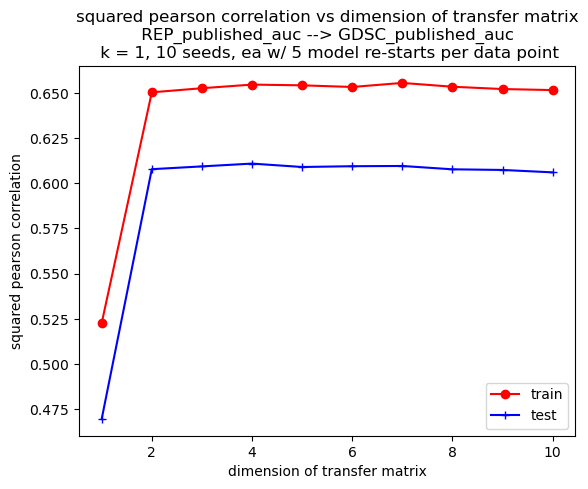

In [63]:
x_axis = range(1, len(train_arr) + 1)
plt.plot(x_axis, train_avg[:, 0], 'r-o', label='train')
plt.plot(x_axis, test_avg[:, 0], 'b-+', label='test')
plt.ylabel('squared pearson correlation')
plt.xlabel('dimension of transfer matrix')
plt.legend(loc="lower right")
title = 'squared pearson correlation vs dimension of transfer matrix\n REP_published_auc --> GDSC_published_auc \n k = 1, 10 seeds, ea w/ 5 model re-starts per data point'
plt.title(title)

Text(0.5, 1.0, 'squared pearson correlation vs dimension of transfer matrix\n REP_published_auc --> GDSC_published_auc \n k = 2, 10 runs per data point')

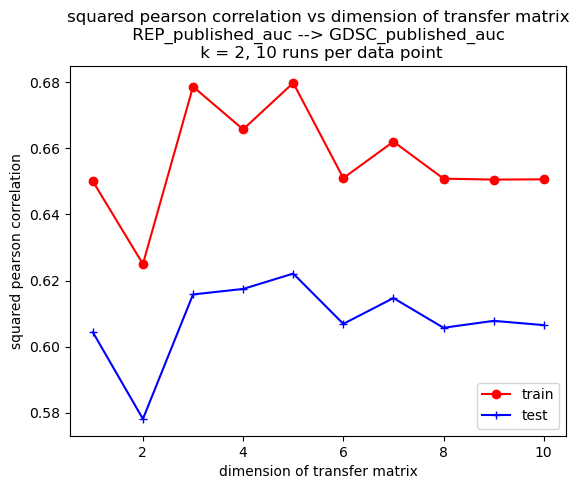

In [64]:
x_axis = range(1, len(train_arr) + 1)
plt.plot(x_axis, train_avg[:, 1], 'r-o', label='train')
plt.plot(x_axis, test_avg[:, 1], 'b-+', label='test')
plt.ylabel('squared pearson correlation')
plt.xlabel('dimension of transfer matrix')
plt.legend(loc="lower right")
title = 'squared pearson correlation vs dimension of transfer matrix\n REP_published_auc --> GDSC_published_auc \n k = 2, 10 runs per data point'
plt.title(title)

In [29]:
r_max = 10
k_max = 2
s_max = 10
m_max = 5
train_full = rsq_arr('train', r_max, k_max, s_max, m_max)
test_full = rsq_arr('test', r_max, k_max, s_max, m_max)

In [30]:
r = 2
k = 2
train_full[r-1, k-1, :, :]

array([[0.62745789, 0.59871924, 0.61458482, 0.60574367, 0.57709139],
       [0.54033891, 0.56938785, 0.59101939, 0.55379002, 0.58508487],
       [0.55016121, 0.54791076, 0.60966564, 0.62335914, 0.47835022],
       [0.56205137, 0.58014216, 0.61442056, 0.3133122 , 0.51754832],
       [0.38525646, 0.59957834, 0.6323197 , 0.60800755, 0.5342078 ],
       [0.59650665, 0.5815866 , 0.41937592, 0.51423492, 0.52686808],
       [0.63826393, 0.60491995, 0.55164211, 0.54622067, 0.51267641],
       [0.59785146, 0.59144532, 0.62681305, 0.50684805, 0.46673334],
       [0.60503104, 0.61099994, 0.64946302, 0.45863189, 0.50728472],
       [0.44692431, 0.65042088, 0.60292094, 0.62183969, 0.57781255]])

In [28]:
(.62 + .59 + .62 + .61 + .63 + .59 + .63 + .62 + .64 + .65) / 10
# 0 ... 2 ... 3 ... 2 ... 2 ... 0 ... 0 ... 2 ... 2 ... 1

0.62

In [31]:
r = 2
k = 2
test_full[r-1, k-1, :, :]

array([[0.56689583, 0.54165603, 0.55424602, 0.53988601, 0.51327127],
       [0.48974911, 0.48031968, 0.52740129, 0.47436703, 0.51396863],
       [0.52640606, 0.51496396, 0.57140923, 0.58485969, 0.43897845],
       [0.54518784, 0.54467753, 0.58254921, 0.31611651, 0.4374106 ],
       [0.34292906, 0.55739909, 0.59751906, 0.57471169, 0.51490233],
       [0.55421002, 0.55823172, 0.39065273, 0.48235369, 0.47630336],
       [0.58735148, 0.58160053, 0.50388354, 0.50021523, 0.47022471],
       [0.57424951, 0.56282331, 0.61324345, 0.49079713, 0.46720373],
       [0.52886891, 0.55532893, 0.57305411, 0.38286868, 0.40180705],
       [0.39639679, 0.59382212, 0.57453566, 0.57522409, 0.5415693 ]])